In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_csv('/content/drive/MyDrive/mw_pw_profiles.txt',low_memory=False)

In [5]:
df_t20 = df[df['match_type'].isin(['T20', 'IT20'])]

In [6]:
df_t20['start_date'] = pd.to_datetime(df_t20['start_date'], errors='coerce')
df_t20 = df_t20.sort_values(by=['player_id', 'start_date'])

/tmp/ipython-input-2796886576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t20['start_date'] = pd.to_datetime(df_t20['start_date'], errors='coerce')


# feature generation

In [7]:
df_t20['strike_rate'] = np.where(df_t20['balls_faced'] != 0, (df_t20['runs_scored'] / df_t20['balls_faced']) * 100, 0)
df_t20['total_boundaries']=df_t20['fours_scored']+df_t20['sixes_scored']
df_t20['run_out_direct']=df_t20['run_out_direct']+df_t20['run_out_throw']
df_t20['fielding']=df_t20['catches_taken']+df_t20['run_out_direct']+df_t20['stumpings_done']
df_t20['economy'] = np.where(df_t20['balls_bowled'] > 0,(df_t20['runs_conceded'] * df_t20['balls_per_over']) / df_t20['balls_bowled'],0)
df_t20['boundary_ratio'] = np.where(df_t20['balls_faced'] != 0, (df_t20['total_boundaries']/ df_t20['balls_faced']), 0)
df_t20['batting_aggression'] = np.where(df_t20['balls_faced'] != 0, ((df_t20['fours_scored'] + 2 * df_t20['sixes_scored']) / df_t20['balls_faced']), 0)
df_t20['bowling_strike_rate'] = np.where(df_t20['wickets_taken'] > 0,(df_t20['balls_bowled'] / df_t20['wickets_taken']),0)
df_t20['dotball_percent_bowler'] = np.where(df_t20['balls_bowled'] > 0,(df_t20['dot_balls_as_bowler'] / df_t20['balls_bowled']),0)
df_t20['impact_score'] = (df_t20['runs_scored'] * 0.5 + df_t20['wickets_taken'] * 12 + df_t20['fielding'])

# Assigning player roles

In [8]:
df_t20 = df_t20[df_t20['order_seen'] != 12]
order_seen_filtered = df_t20['order_seen'].where(df_t20['order_seen'] != 0)

df_t20['rolling_order'] = (
    df_t20.groupby('player_id')[order_seen_filtered.name]
      .transform(lambda x: x.shift(1).dropna().rolling(window=3, min_periods=1).mean())
)

df_t20['rolling_bowled'] = (
    df_t20.groupby('player_id')['balls_bowled']
      .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
)

def classify_role(row):
    if pd.isna(row['rolling_order']) and row['rolling_bowled'] > 6:
        return 'bowler'
    elif pd.isna(row['rolling_bowled']) and row['rolling_order'] > 0:
        return 'batsman'
    elif row['rolling_order'] <= 5 and row['rolling_bowled'] < 6:
        return 'batsman'
    elif row['rolling_order'] >= 6 and row['rolling_bowled'] >= 6:
        return 'all-rounder'
    elif row['rolling_bowled'] >= 12:
        return 'bowler'
    elif row['rolling_order'] <= 6:
        return 'batsman'
    else:
        return 'all-rounder'

df_t20['player_role'] = df_t20.apply(classify_role, axis=1)

In [9]:
df_t20['player_role'].value_counts()

,count
player_role,
batsman,128010
bowler,113564
all-rounder,18128


In [10]:
df_t20=df_t20.drop(['order_seen','stumpings_done','balls_per_over','key_cricinfo','gender','run_out_direct','catches_taken','run_out_throw','lbw_done','bowled_done','teams','out_kind','name_y','unique_name','run_out_throw','key_bcci','key_bcci_2','key_bigbash','key_cricbuzz','key_cricheroes','key_crichq','key_cricinfo_2','key_cricinfo_3','key_cricingif','key_cricketarchive','key_cricketarchive_2','key_cricketworld','key_nvplay','key_nvplay_2','key_opta','key_opta_2','key_pulse','key_pulse_2','full_name','batting_style','bowling_style','playing_role'],axis=1,errors='ignore')

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_t20['player_team_encoded'] = le.fit_transform(df_t20['player_team'].astype(str))
df_t20['opposition_team_encoded'] = le.fit_transform(df_t20['opposition_team'].astype(str))

In [12]:
df_enriched=df_t20[['player_id','start_date','match_id','player_role','fantasy_score_total','player_team_encoded','opposition_team_encoded']]
df_enriched = df_enriched.sort_values(by=['player_id', 'start_date'])

# calc rolling features

In [13]:
rolling_features = [
    'runs_scored', 'balls_faced', 'total_boundaries','balls_bowled','fantasy_score_batting','fantasy_score_bowling','batting_aggression','bowling_strike_rate','dotball_percent_bowler','impact_score',
    'wickets_taken', 'dot_balls_as_bowler',
    'runs_conceded', 'fantasy_score_total', 'strike_rate', 'economy','boundary_ratio',
]

window_size = [3,5,10]
for win in window_size:
  for col in rolling_features:
      df_enriched[f'rolling{win}_{col}'] = (
          df_t20
          .sort_values(['player_id', 'start_date'])
          .groupby('player_id')[col]
          .transform(lambda x: x.shift(1).rolling(window=win, min_periods=1).mean())
      )

In [14]:
df_enriched = df_enriched.groupby('player_id', group_keys=False).apply(lambda g: g.iloc[1:]).reset_index(drop=True)


/tmp/ipython-input-1967713865.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_enriched = df_enriched.groupby('player_id', group_keys=False).apply(lambda g: g.iloc[1:]).reset_index(drop=True)


# target encoding player team, opposition team, player roles

In [15]:
from sklearn.model_selection import KFold
import numpy as np

cat_cols = ['player_team_encoded', 'opposition_team_encoded', 'player_role']
target_col = 'fantasy_score_total'

def kfold_target_encoding(df, target_col, cat_cols, n_splits=5):
    df_encoded = df.copy()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for col in cat_cols:
        new_col = f"{col}_enc"
        df_encoded[new_col] = np.nan

        for train_idx, val_idx in kf.split(df):
            train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
            means = train_df.groupby(col)[target_col].mean()
            df_encoded.iloc[val_idx, df_encoded.columns.get_loc(new_col)] = val_df[col].map(means)

        df_encoded[new_col] = df_encoded[new_col].fillna(df[target_col].mean())

    return df_encoded

df_encoded = kfold_target_encoding(df_enriched, target_col, cat_cols)
df_dqn=df_encoded.copy()
df_dqn=df_dqn.drop(columns=['player_role'])
df_encoded = df_encoded.drop(columns=cat_cols)

In [16]:
df_dqn.columns

Index(['player_id', 'start_date', 'match_id', 'fantasy_score_total',
       'player_team_encoded', 'opposition_team_encoded',
       'rolling3_runs_scored', 'rolling3_balls_faced',
       'rolling3_total_boundaries', 'rolling3_balls_bowled',
       'rolling3_fantasy_score_batting', 'rolling3_fantasy_score_bowling',
       'rolling3_batting_aggression', 'rolling3_bowling_strike_rate',
       'rolling3_dotball_percent_bowler', 'rolling3_impact_score',
       'rolling3_wickets_taken', 'rolling3_dot_balls_as_bowler',
       'rolling3_runs_conceded', 'rolling3_fantasy_score_total',
       'rolling3_strike_rate', 'rolling3_economy', 'rolling3_boundary_ratio',
       'rolling5_runs_scored', 'rolling5_balls_faced',
       'rolling5_total_boundaries', 'rolling5_balls_bowled',
       'rolling5_fantasy_score_batting', 'rolling5_fantasy_score_bowling',
       'rolling5_batting_aggression', 'rolling5_bowling_strike_rate',
       'rolling5_dotball_percent_bowler', 'rolling5_impact_score',
       'ro

In [17]:
df_encoded.head()

,player_id,start_date,match_id,fantasy_score_total,rolling3_runs_scored,rolling3_balls_faced,rolling3_total_boundaries,rolling3_balls_bowled,rolling3_fantasy_score_batting,rolling3_fantasy_score_bowling,...,rolling10_wickets_taken,rolling10_dot_balls_as_bowler,rolling10_runs_conceded,rolling10_fantasy_score_total,rolling10_strike_rate,rolling10_economy,rolling10_boundary_ratio,player_team_encoded_enc,opposition_team_encoded_enc,player_role_enc
0,00015688,2019-05-05,1182644,7,10.000000,30.000000,1.000000,0.0,5.000000,8.000000,...,0.0,0.0,0.0,17.000000,33.333333,0.0,0.033333,31.809417,31.578810,32.795752
1,00015688,2021-09-09,1275107,5,9.000000,24.000000,1.000000,0.0,4.000000,4.000000,...,0.0,0.0,0.0,12.000000,38.888889,0.0,0.044444,31.809417,33.364055,32.795752
2,00015688,2021-09-14,1275125,-1,6.333333,17.666667,0.666667,0.0,3.000000,2.666667,...,0.0,0.0,0.0,9.666667,32.592593,0.0,0.029630,32.766816,31.414683,32.770060
3,00015688,2021-09-15,1275113,4,3.333333,12.666667,0.333333,0.0,-0.333333,0.000000,...,0.0,0.0,0.0,7.000000,26.111111,0.0,0.022222,33.193764,40.225664,32.823387
4,00029c30,2021-10-16,1283024,4,0.000000,0.000000,0.000000,12.0,0.000000,33.000000,...,1.0,6.0,16.0,33.000000,0.000000,8.0,0.000000,29.717314,31.693243,41.166010


In [21]:
numeric_df = df_encoded.select_dtypes(include='number')
corr = numeric_df.corr()
corr

,fantasy_score_total,rolling3_runs_scored,rolling3_balls_faced,rolling3_total_boundaries,rolling3_balls_bowled,rolling3_fantasy_score_batting,rolling3_fantasy_score_bowling,rolling3_batting_aggression,rolling3_bowling_strike_rate,rolling3_dotball_percent_bowler,...,rolling10_wickets_taken,rolling10_dot_balls_as_bowler,rolling10_runs_conceded,rolling10_fantasy_score_total,rolling10_strike_rate,rolling10_economy,rolling10_boundary_ratio,player_team_encoded_enc,opposition_team_encoded_enc,player_role_enc
fantasy_score_total,1.000000,0.093781,0.070525,0.099948,0.135180,0.095308,0.125748,0.086734,0.110978,0.124815,...,0.124236,0.122572,0.118190,0.218926,0.089982,0.105238,0.096487,0.081745,0.061839,0.124755
rolling3_runs_scored,0.093781,1.000000,0.931876,0.962263,-0.435957,0.992229,-0.301890,0.633800,-0.341438,-0.417417,...,-0.390410,-0.442839,-0.441077,0.363873,0.660290,-0.414793,0.618321,0.103263,0.056835,-0.406717
rolling3_balls_faced,0.070525,0.931876,1.000000,0.845747,-0.475356,0.894768,-0.335651,0.479582,-0.376288,-0.439191,...,-0.433094,-0.468657,-0.495321,0.282929,0.595847,-0.465841,0.528017,0.007251,0.003118,-0.443151
rolling3_total_boundaries,0.099948,0.962263,0.845747,1.000000,-0.404789,0.971368,-0.278963,0.698007,-0.315775,-0.391296,...,-0.359800,-0.412911,-0.404985,0.371492,0.644435,-0.383383,0.659884,0.119782,0.068906,-0.376595
rolling3_balls_bowled,0.135180,-0.435957,-0.475356,-0.404789,1.000000,-0.426652,0.729090,-0.292848,0.799316,0.890011,...,0.819228,0.912318,0.910265,0.327439,-0.460707,0.833251,-0.409596,0.019547,0.001685,0.911195
rolling3_fantasy_score_batting,0.095308,0.992229,0.894768,0.971368,-0.426652,1.000000,-0.292743,0.655200,-0.332771,-0.412403,...,-0.379744,-0.435617,-0.428409,0.372465,0.655944,-0.405188,0.625263,0.121655,0.065844,-0.397066
rolling3_fantasy_score_bowling,0.125748,-0.301890,-0.335651,-0.278963,0.729090,-0.292743,1.000000,-0.201744,0.682951,0.717429,...,0.814939,0.698198,0.611290,0.505949,-0.319413,0.535838,-0.282313,0.034290,-0.010400,0.659796
rolling3_batting_aggression,0.086734,0.633800,0.479582,0.698007,-0.292848,0.655200,-0.201744,1.000000,-0.226590,-0.298656,...,-0.254544,-0.315171,-0.272853,0.274271,0.724537,-0.249465,0.769473,0.142481,0.096023,-0.284222
rolling3_bowling_strike_rate,0.110978,-0.341438,-0.376288,-0.315775,0.799316,-0.332771,0.682951,-0.226590,1.000000,0.702779,...,0.710440,0.726174,0.712926,0.320738,-0.360122,0.628154,-0.318350,0.033636,0.008958,0.722709
rolling3_dotball_percent_bowler,0.124815,-0.417417,-0.439191,-0.391296,0.890011,-0.412403,0.717429,-0.298656,0.702779,1.000000,...,0.760937,0.911778,0.773512,0.309934,-0.453266,0.748184,-0.407308,-0.050631,-0.060896,0.817444


In [22]:
df_train_features = df_encoded[df_encoded['start_date'] < '2024-12-01']
df_test_features = df_encoded[df_encoded['start_date'] >= '2024-12-01']

In [23]:
X_train = df_train_features.drop(['fantasy_score_total','start_date','player_id','match_id'], axis = 1)
y_train = df_train_features['fantasy_score_total']

X_test = df_test_features.drop(['fantasy_score_total','start_date','player_id','match_id'], axis = 1)
y_test = df_test_features['fantasy_score_total']

In [24]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [25]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import RidgeCV


xgb = XGBRegressor(
    learning_rate=0.0247,
    max_depth=5,
    n_estimators=714,
    subsample=0.85,
    colsample_bytree=0.80,
    reg_alpha=0.5,
    reg_lambda=1.0,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    verbosity=0)


cat = CatBoostRegressor(
    learning_rate=0.04,
    depth=6,
    subsample=0.8,
    colsample_bylevel=0.75,
    random_seed=42,
    loss_function='RMSE',
    verbose=0
)

ensemble = StackingRegressor(
    estimators=[
        ('xgb', xgb),
        ('cat', cat)
    ],
    final_estimator=RidgeCV(),
    n_jobs=-1
)

print("Training Stacking Ensemble...")
ensemble.fit(X_train, y_train)

Training Stacking Ensemble...


StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constrai...
                                            learning_rate=0.0247, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=714, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x78fa7bd572d0>)],
                  final_estimator=RidgeCV(), n_jobs=-1)

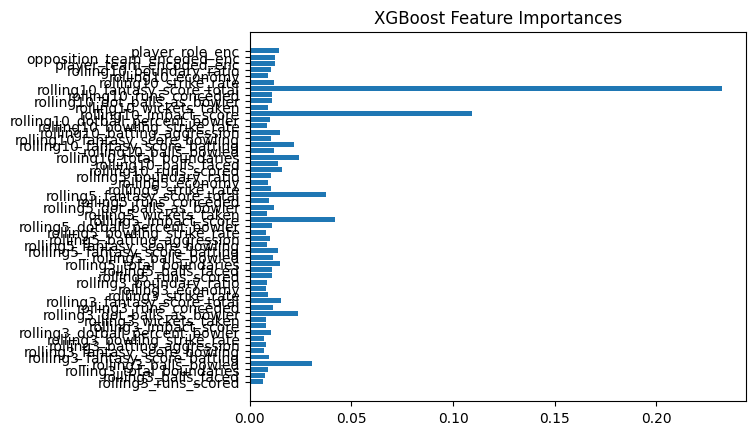

In [26]:
xgb.fit(X_train, y_train)
xgb_importances = xgb.feature_importances_

plt.barh(X_train.columns, xgb_importances)
plt.title("XGBoost Feature Importances")
plt.show()

In [27]:
y_pred = ensemble.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")

R2 Score: 0.0889
MAE: 24.9674


In [28]:
df_predictions = pd.DataFrame({
    'player_id': df_test_features['player_id'],
    'match_id': df_test_features['match_id'],
    'fantasy_score_total': df_test_features['fantasy_score_total'],
    'predicted_score': y_pred
})

df_predictions.head()

,player_id,match_id,fantasy_score_total,predicted_score
27,0030a57d,1474423,20,14.429152
28,0030a57d,1474424,16,16.686788
29,0030a57d,1474429,2,12.564363
99,003d49e6,1443059,60,29.353272
100,003d49e6,1443062,22,32.291054


In [29]:
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

# Group by match
match_metrics = []

for match_id, df_predictions_match in df_predictions.groupby('match_id'):
    # Sort by predicted and actual scores
    top11_pred = df_predictions_match.sort_values(by=df_predictions_match.columns[df_predictions_match.columns.get_loc('predicted_score')], ascending=False).head(11)
    top11_actual = df_predictions_match.sort_values(by='fantasy_score_total', ascending=False).head(11)

    # Overlap in player_ids
    overlap = len(set(top11_pred['player_id']) & set(top11_actual['player_id']))

    # MAPE between summed top11 scores
    pred_sum = top11_pred['predicted_score'].sum()
    actual_sum = top11_actual['fantasy_score_total'].sum()

    if actual_sum == 0:
        mape = None  # or skip this match
    else:
        mape = abs(actual_sum - pred_sum) / actual_sum * 100

    match_metrics.append({
        'match_id': match_id,
        'overlap_count': overlap,
        'overlap_pct': overlap / 11 * 100,
        'actual_sum': actual_sum,
        'predicted_sum': pred_sum,
        'mape': mape
    })

# Create result dataframe
metrics_df = pd.DataFrame(match_metrics)

# Summary metrics
print("\nEvaluation Summary:")
print(f"Average Overlap: {metrics_df['overlap_pct'].mean():.2f}%")
print(f"Average MAPE: {metrics_df['mape'].mean():.2f}%")


Evaluation Summary:
Average Overlap: 60.62%
Average MAPE: 31.00%


In [30]:
metrics_df.head()

,match_id,overlap_count,overlap_pct,actual_sum,predicted_sum,mape
0,1426626,7,63.636364,751,533.142694,29.008962
1,1426627,5,45.454545,627,524.027517,16.423043
2,1426628,6,54.545455,637,490.080492,23.064287
3,1432211,7,63.636364,853,465.355988,45.444785
4,1432212,6,54.545455,777,481.741637,37.999789


In [31]:
(df_encoded['match_id'].value_counts()>=11).value_counts()

,count
count,
True,11602


In [18]:
df_encoded = df_encoded[df_encoded['match_id'].map(df_encoded['match_id'].value_counts()) >= 11]

# RL APPROACH

In [20]:
import pandas as pd
import numpy as np
import collections
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import sys

# Set a consistent random seed for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# --- Dummy Data Generation matching the user's column list ---
# This dictionary creates a mock DataFrame with the exact column names and types
# provided by the user.
NUM_PLAYERS_TOTAL = 220
NUM_MATCHES = 10
columns = [
    'player_id', 'start_date', 'match_id', 'fantasy_score_total',
    'player_team_encoded', 'opposition_team_encoded',
    'rolling3_runs_scored', 'rolling3_balls_faced',
    'rolling3_total_boundaries', 'rolling3_balls_bowled',
    'rolling3_fantasy_score_batting', 'rolling3_fantasy_score_bowling',
    'rolling3_batting_aggression', 'rolling3_bowling_strike_rate',
    'rolling3_dotball_percent_bowler', 'rolling3_impact_score',
    'rolling3_wickets_taken', 'rolling3_dot_balls_as_bowler',
    'rolling3_runs_conceded', 'rolling3_fantasy_score_total',
    'rolling3_strike_rate', 'rolling3_economy', 'rolling3_boundary_ratio',
    'rolling5_runs_scored', 'rolling5_balls_faced',
    'rolling5_total_boundaries', 'rolling5_balls_bowled',
    'rolling5_fantasy_score_batting', 'rolling5_fantasy_score_bowling',
    'rolling5_batting_aggression', 'rolling5_bowling_strike_rate',
    'rolling5_dotball_percent_bowler', 'rolling5_impact_score',
    'rolling5_wickets_taken', 'rolling5_dot_balls_as_bowler',
    'rolling5_runs_conceded', 'rolling5_fantasy_score_total',
    'rolling5_strike_rate', 'rolling5_economy', 'rolling5_boundary_ratio',
    'rolling10_runs_scored', 'rolling10_balls_faced',
    'rolling10_total_boundaries', 'rolling10_balls_bowled',
    'rolling10_fantasy_score_batting', 'rolling10_fantasy_score_bowling',
    'rolling10_batting_aggression', 'rolling10_bowling_strike_rate',
    'rolling10_dotball_percent_bowler', 'rolling10_impact_score',
    'rolling10_wickets_taken', 'rolling10_dot_balls_as_bowler',
    'rolling10_runs_conceded', 'rolling10_fantasy_score_total',
    'rolling10_strike_rate', 'rolling10_economy',
    'rolling10_boundary_ratio', 'player_team_encoded_enc',
    'opposition_team_encoded_enc', 'player_role_enc'
]

df_dqn = pd.DataFrame(columns=columns)
df_dqn['player_id'] = [f'player_{i}' for i in range(NUM_PLAYERS_TOTAL)]
df_dqn['match_id'] = [f'match_{i // 22}' for i in range(NUM_PLAYERS_TOTAL)]
df_dqn['start_date'] = pd.to_datetime('2023-01-01')
for col in columns:
    if col.startswith('rolling'):
        df_dqn[col] = np.random.rand(NUM_PLAYERS_TOTAL) * 10
    elif 'enc' in col:
        df_dqn[col] = np.random.randint(0, 5, NUM_PLAYERS_TOTAL)
    elif col in ['fantasy_score_total', 'player_team_encoded', 'opposition_team_encoded']:
        df_dqn[col] = np.random.randint(0, 100, NUM_PLAYERS_TOTAL)

# --- Define the core RL classes ---
class TeamSwapEnv:
    def __init__(self, player_feats, ideal_idxs, max_swaps=30):
        self.obs_feature_cols = [
            'rolling3_runs_scored', 'rolling3_balls_faced', 'rolling3_total_boundaries',
            'rolling3_balls_bowled', 'rolling3_fantasy_score_batting',
            'rolling3_fantasy_score_bowling', 'rolling3_batting_aggression',
            'rolling3_bowling_strike_rate', 'rolling3_dotball_percent_bowler',
            'rolling3_impact_score', 'rolling3_wickets_taken',
            'rolling3_dot_balls_as_bowler', 'rolling3_runs_conceded',
            'rolling3_strike_rate', 'rolling3_economy', 'rolling3_boundary_ratio',
            'rolling5_runs_scored', 'rolling5_balls_faced', 'rolling5_total_boundaries',
            'rolling5_balls_bowled', 'rolling5_fantasy_score_batting',
            'rolling5_fantasy_score_bowling', 'rolling5_batting_aggression',
            'rolling5_bowling_strike_rate', 'rolling5_dotball_percent_bowler',
            'rolling5_impact_score', 'rolling5_wickets_taken',
            'rolling5_dot_balls_as_bowler', 'rolling5_runs_conceded',
            'rolling5_strike_rate', 'rolling5_economy', 'rolling5_boundary_ratio',
            'rolling10_runs_scored', 'rolling10_balls_faced', 'rolling10_total_boundaries',
            'rolling10_balls_bowled', 'rolling10_fantasy_score_batting',
            'rolling10_fantasy_score_bowling', 'rolling10_batting_aggression',
            'rolling10_bowling_strike_rate', 'rolling10_dotball_percent_bowler',
            'rolling10_impact_score', 'rolling10_wickets_taken',
            'rolling10_dot_balls_as_bowler', 'rolling10_runs_conceded',
            'rolling10_strike_rate', 'rolling10_economy', 'rolling10_boundary_ratio',
            'player_team_encoded_enc', 'opposition_team_encoded_enc', 'player_role_enc'
        ]

        # --- End of observation feature columns definition ---
        self.player_feats = player_feats.reset_index(drop=True)
        self.player_feats["player_code"], uniques = pd.factorize(self.player_feats["player_id"])
        code_map = dict(zip(self.player_feats["player_id"], self.player_feats["player_code"]))
        self.ideal_codes = {code_map[i] for i in ideal_idxs}

        self.ideal_player_scores_map = {}
        for player_id in ideal_idxs:
            player_code = code_map[player_id]
            score = self.player_feats[self.player_feats['player_id'] == player_id]['fantasy_score_total'].iloc[0]
            self.ideal_player_scores_map[player_code] = score
        self.ideal_total_fantasy_score = sum(self.ideal_player_scores_map.values())

        self.max_swaps = max_swaps
        self.id_flag = np.zeros((22, 2), dtype=np.float32)
        self.n_actions = 11 * 11 + 1
        self.reset()

    def _get_obs(self):
        obs_feats = self.player_feats[self.obs_feature_cols].values.flatten().astype(np.float32)

        start_row_indices = self.player_feats[self.player_feats["player_code"].isin(self.start_player_codes)].index.tolist()

        self.id_flag[:, 1] = 0.0
        for idx in start_row_indices:
            if idx < 22:
                self.id_flag[idx, 1] = 1.0

        self.id_flag[:, 0] = self.player_feats["player_code"].values

        team_counts = self.player_feats.loc[start_row_indices, "player_team_encoded"].value_counts()
        max_team_count = team_counts.max() if not team_counts.empty else 0

        return np.concatenate([obs_feats, self.id_flag.flatten(), [max_team_count]])

    def _reward(self):
        start_row_indices = self.player_feats[self.player_feats["player_code"].isin(self.start_player_codes)].index.tolist()

        agent_selected_total_score = 0
        for idx in start_row_indices:
            agent_selected_total_score += self.player_feats.loc[idx, "fantasy_score_total"]

        mape_val = 0.0
        if self.ideal_total_fantasy_score == 0:
            if agent_selected_total_score != 0:
                mape_val = 1000.0
        else:
            mape_val = np.abs((self.ideal_total_fantasy_score - agent_selected_total_score) / self.ideal_total_fantasy_score) * 100

        reward_from_mape = 100 - mape_val

        team_counts = self.player_feats.loc[start_row_indices, "player_team_encoded"].value_counts()
        max_team_count = team_counts.max() if not team_counts.empty else 0

        team_balance_penalty = 0
        if max_team_count > 7 or max_team_count < 4:
            team_balance_penalty = -200

        reward = reward_from_mape + team_balance_penalty
        return reward

    def reset(self):
        all_player_indices = self.player_feats.index.tolist()
        random.shuffle(all_player_indices)

        self.start_player_codes = [self.player_feats.loc[idx, "player_code"] for idx in all_player_indices[:11]]
        self.bench_player_codes = [self.player_feats.loc[idx, "player_code"] for idx in all_player_indices[11:]]

        self.swap_cnt = 0
        return self._get_obs()

    def step(self, action: int):
        if action == self.n_actions - 1:
            reward = self._reward()
            self.swap_cnt += 1
            done = self.swap_cnt >= self.max_swaps
            return self._get_obs(), reward, done

        team_slot, bench_slot = divmod(action, 11)

        if not (0 <= team_slot < len(self.start_player_codes) and 0 <= bench_slot < len(self.bench_player_codes)):
            reward = -50
            done = True
            return self._get_obs(), reward, done

        team_player_code = self.start_player_codes[team_slot]
        bench_player_code = self.bench_player_codes[bench_slot]

        self.start_player_codes[team_slot] = bench_player_code
        self.bench_player_codes[bench_slot] = team_player_code

        reward = self._reward()
        self.swap_cnt += 1
        done = self.swap_cnt >= self.max_swaps
        return self._get_obs(), reward, done

Transition = collections.namedtuple("Transition", ("state", "action", "reward", "next_state", "done"))

class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    def __init__(self, obs_dim, n_actions, hidden=128):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions),
        )

    def forward(self, x):
        return self.layers(x)

def match_ids_with_22_players(df, match_col="match_id", expected_players=22):
    counts = df[match_col].value_counts()
    valid_ids = counts[counts == expected_players].index.tolist()
    return valid_ids

match_ids_array = match_ids_with_22_players(df_dqn)

def ideal_ids(df1):
    top_ids = df1.nlargest(11, "fantasy_score_total")["player_id"].tolist()
    return top_ids

def calculate_mape_for_team_report(ideal_player_codes, final_selected_codes, player_feats_df):
    ideal_scores = []
    for code in ideal_player_codes:
        score_series = player_feats_df[player_feats_df["player_code"] == code]["fantasy_score_total"]
        if not score_series.empty:
            ideal_scores.append(score_series.iloc[0])

    agent_scores = []
    for code in final_selected_codes:
        score_series = player_feats_df[player_feats_df["player_code"] == code]["fantasy_score_total"]
        if not score_series.empty:
            agent_scores.append(score_series.iloc[0])

    actual_total = sum(ideal_scores)
    predicted_total = sum(agent_scores)

    if actual_total == 0:
        return 0.0
    mape = np.abs((actual_total - predicted_total) / actual_total) * 100
    return mape

# --- Supervised Learning Model Placeholder ---
def train_fantasy_score_predictor(df_history):
    features = [
        'rolling3_runs_scored', 'rolling3_balls_faced', 'rolling3_total_boundaries',
        'rolling3_balls_bowled', 'rolling3_fantasy_score_batting',
        'rolling3_fantasy_score_bowling', 'rolling3_batting_aggression',
        'rolling3_bowling_strike_rate', 'rolling3_dotball_percent_bowler',
        'rolling3_impact_score', 'rolling3_wickets_taken',
        'rolling3_dot_balls_as_bowler', 'rolling3_runs_conceded',
        'rolling3_strike_rate', 'rolling3_economy', 'rolling3_boundary_ratio',
        'rolling5_runs_scored', 'rolling5_balls_faced', 'rolling5_total_boundaries',
        'rolling5_balls_bowled', 'rolling5_fantasy_score_batting',
        'rolling5_fantasy_score_bowling', 'rolling5_batting_aggression',
        'rolling5_bowling_strike_rate', 'rolling5_dotball_percent_bowler',
        'rolling5_impact_score', 'rolling5_wickets_taken',
        'rolling5_dot_balls_as_bowler', 'rolling5_runs_conceded',
        'rolling5_strike_rate', 'rolling5_economy', 'rolling5_boundary_ratio',
        'rolling10_runs_scored', 'rolling10_balls_faced', 'rolling10_total_boundaries',
        'rolling10_balls_bowled', 'rolling10_fantasy_score_batting',
        'rolling10_fantasy_score_bowling', 'rolling10_batting_aggression',
        'rolling10_bowling_strike_rate', 'rolling10_dotball_percent_bowler',
        'rolling10_impact_score', 'rolling10_wickets_taken',
        'rolling10_dot_balls_as_bowler', 'rolling10_runs_conceded',
        'rolling10_strike_rate', 'rolling10_economy', 'rolling10_boundary_ratio',
        'player_team_encoded_enc', 'opposition_team_encoded_enc', 'player_role_enc'
    ]
    target = 'fantasy_score_total'

    df_clean = df_history.dropna(subset=features + [target])

    X = df_clean[features]
    y = df_clean[target]

    predictor = RandomForestRegressor(n_estimators=100, random_state=42)
    predictor.fit(X, y)

    return predictor, features

# --- RL Training Function ---
def train_agent(episodes=500, gamma=0.9, lr=0.1, batch_size=64, epsilon_start=1.0, epsilon_final=0.05, epsilon_decay=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_total_rewards = []
    all_mape_scores_for_report = []
    all_ideal_player_percentages = []

    current_step = 0
    initial_epsilon = epsilon_start
    final_epsilon = epsilon_final
    decay_speed = 30000

    match_data = df_dqn[df_dqn['match_id'] == match_ids_array[0]].copy()
    temp_env = TeamSwapEnv(player_feats=match_data,
                           ideal_idxs=ideal_ids(match_data))
    obs_dim = temp_env._get_obs().shape[0]
    n_actions = temp_env.n_actions
    del temp_env

    policy_net = DQN(obs_dim, n_actions).to(device)
    target_net = DQN(obs_dim, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay_buffer = ReplayBuffer()

    for episode in range(episodes):
        match_data = df_dqn[df_dqn['match_id'] == match_ids_array[(episode % len(match_ids_array))]].copy()
        env = TeamSwapEnv(player_feats=match_data,
                          ideal_idxs=ideal_ids(match_data))

        state = env.reset()
        total_reward = 0

        for t in range(env.max_swaps):
            epsilon = final_epsilon + (initial_epsilon - final_epsilon) * np.exp(-current_step / decay_speed)
            current_step += 1

            if random.random() < epsilon:
                action = random.randint(0, n_actions - 1)
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()

            next_state, reward, done = env.step(action)
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(replay_buffer) > batch_size:
                s, a, r, s_, d = replay_buffer.sample(batch_size)
                s = torch.tensor(np.array(s), dtype=torch.float32).to(device)
                a = torch.tensor(np.array(a), dtype=torch.int64).to(device)
                r = torch.tensor(np.array(r), dtype=torch.float32).to(device)
                s_ = torch.tensor(np.array(s_), dtype=torch.float32).to(device)
                d = torch.tensor(np.array(d), dtype=torch.float32).to(device)

                q_values = policy_net(s).gather(1, a.unsqueeze(1)).squeeze(1)
                next_q_values = target_net(s_).max(1)[0]
                expected_q = r + gamma * next_q_values * (1 - d)
                loss = nn.MSELoss()(q_values, expected_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        all_total_rewards.append(total_reward)
        final_selected_codes = set(env.start_player_codes)
        correct_final = sum(int(pid in env.ideal_codes) for pid in final_selected_codes)
        ideal_player_percentage = (correct_final / 11) * 100
        all_ideal_player_percentages.append(ideal_player_percentage)
        current_mape_report = calculate_mape_for_team_report(env.ideal_codes, final_selected_codes, env.player_feats)
        all_mape_scores_for_report.append(current_mape_report)

        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())
            print(f"Episode {episode}, Total reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}, "
                  f"Ideal Players %: {ideal_player_percentage:.2f}%, Reported MAPE (Fantasy Score): {current_mape_report:.2f}%")

    print("\nTraining complete.")
    model_save_path = "dqn_team_swap_model_mape_reward_pos_neg.pth"
    torch.save(policy_net.state_dict(), model_save_path)
    print(f"Policy network weights saved to {model_save_path}")

    return policy_net, obs_dim, n_actions

# --- New Prediction Function ---
def predict_top_11(player_data_for_new_match, rl_policy_net, fantasy_score_predictor, pred_features, obs_dim, n_actions, max_swaps=30):
    """
    Predicts the top 11 players for a new match using a trained RL policy and reports metrics.
    """
    print("\n--- Starting Prediction for a New Match ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    prediction_df = player_data_for_new_match.copy()

    try:
        prediction_df['predicted_fantasy_score'] = fantasy_score_predictor.predict(prediction_df[pred_features])
    except KeyError as e:
        print(f"Error: Missing feature column in prediction data: {e}")
        print("Required features:", pred_features)
        print("Available columns:", prediction_df.columns)
        return None

    prediction_df['fantasy_score_total'] = prediction_df['predicted_fantasy_score']

    predicted_ideal_ids = prediction_df.nlargest(11, 'predicted_fantasy_score')['player_id'].tolist()

    ideal_predicted_scores = prediction_df[prediction_df['player_id'].isin(predicted_ideal_ids)]['predicted_fantasy_score'].sum()

    env = TeamSwapEnv(
        player_feats=prediction_df,
        ideal_idxs=predicted_ideal_ids,
        max_swaps=max_swaps
    )

    current_obs_dim = env._get_obs().shape[0]
    if current_obs_dim != obs_dim:
        raise RuntimeError(f"Observation dimension mismatch! Model expects {obs_dim}, but environment provides {current_obs_dim}. "
                           "This is likely due to inconsistent feature columns between training and prediction.")

    state = env.reset()
    rl_policy_net.eval()

    for t in range(max_swaps):
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            q_values = rl_policy_net(state_tensor)
            action = q_values.argmax().item()

        next_state, _, done = env.step(action)
        state = next_state
        if done:
            break

    final_player_codes = env.start_player_codes
    code_to_id_map = dict(zip(env.player_feats['player_code'], env.player_feats['player_id']))
    final_player_ids = [code_to_id_map[code] for code in final_player_codes]

    final_team_predicted_scores = prediction_df[prediction_df['player_id'].isin(final_player_ids)]['predicted_fantasy_score'].sum()

    mape_final = 0.0
    if ideal_predicted_scores == 0:
        if final_team_predicted_scores != 0:
            mape_final = 1000.0
    else:
        mape_final = np.abs((ideal_predicted_scores - final_team_predicted_scores) / ideal_predicted_scores) * 100

    print("\n--- Prediction Results ---")
    print(f"Predicted Top 11 Player IDs: {final_player_ids}")
    print(f"Total Predicted Fantasy Score (Ideal Team): {ideal_predicted_scores:.2f}")
    print(f"Total Predicted Fantasy Score (Agent's Final Team): {final_team_predicted_scores:.2f}")
    print(f"MAPE of Final Team vs. Ideal Team: {mape_final:.2f}%")
    print("Prediction complete.")

    return final_player_ids

# --- Main Execution Block ---
if __name__ == "__main__":
    print("Step 1: Training Fantasy Score Predictor...")
    fantasy_score_predictor, pred_features = train_fantasy_score_predictor(df_dqn)
    print(f"Fantasy Score Predictor trained on features: {pred_features}")

    print("\nStep 2: Training RL Agent (500 episodes)...")
    policy_net, obs_dim, n_actions = train_agent(episodes=500)

    print("\nStep 3: Simulating new match data for prediction...")
    new_match_data = df_dqn[df_dqn['match_id'] == 'match_9'].copy()
    new_match_data['fantasy_score_total'] = np.nan

    print("\nStep 4: Make the Prediction...")
    predict_top_11(new_match_data, policy_net, fantasy_score_predictor, pred_features, obs_dim, n_actions)




Step 1: Training Fantasy Score Predictor...
Fantasy Score Predictor trained on features: ['rolling3_runs_scored', 'rolling3_balls_faced', 'rolling3_total_boundaries', 'rolling3_balls_bowled', 'rolling3_fantasy_score_batting', 'rolling3_fantasy_score_bowling', 'rolling3_batting_aggression', 'rolling3_bowling_strike_rate', 'rolling3_dotball_percent_bowler', 'rolling3_impact_score', 'rolling3_wickets_taken', 'rolling3_dot_balls_as_bowler', 'rolling3_runs_conceded', 'rolling3_strike_rate', 'rolling3_economy', 'rolling3_boundary_ratio', 'rolling5_runs_scored', 'rolling5_balls_faced', 'rolling5_total_boundaries', 'rolling5_balls_bowled', 'rolling5_fantasy_score_batting', 'rolling5_fantasy_score_bowling', 'rolling5_batting_aggression', 'rolling5_bowling_strike_rate', 'rolling5_dotball_percent_bowler', 'rolling5_impact_score', 'rolling5_wickets_taken', 'rolling5_dot_balls_as_bowler', 'rolling5_runs_conceded', 'rolling5_strike_rate', 'rolling5_economy', 'rolling5_boundary_ratio', 'rolling10_run